In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from utils import *
from img_utils import *

# Loading Data 

In [11]:
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)
print("Number of datapoints of type 'Ejerlejlighed': ", len(houses_df))
display(houses_df)

[ WARN:0@29.301] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@31.584] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity


Number of datapoints of type 'Ejerlejlighed':  362


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1995000,70,None,2,1968,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Aggersborggade 9 1. tv 2100 København Ø,2100,ejerlejlighed,5650000,80,None,3,1896,1933.0,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Ahornsgade 9 4. th 2200 København N,2200,ejerlejlighed,3195000,51,None,2,1886,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Akacieparken 10B 2. 24 2680 Solrød Strand,2680,ejerlejlighed,1995000,61,None,2,1975,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,Akacieparken 11B 2. 59 2680 Solrød Strand,2680,ejerlejlighed,3350000,104,None,3,1975,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...,...,...,...,...
357,Øster Allé 22 1. 2100 København Ø,2100,ejerlejlighed,9995000,122,None,4,1900,NaN,B,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
358,Østerbrogade 206 4. tv 2100 København Ø,2100,ejerlejlighed,4295000,77,None,3,1938,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
359,Østerbrogade 224 1. th 2100 København Ø,2100,ejerlejlighed,3645000,70,None,2,1938,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
360,Østerparken 3 1. 1 2630 Taastrup,2630,ejerlejlighed,1199000,37,None,2,1963,NaN,E,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


# Setting up splits

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

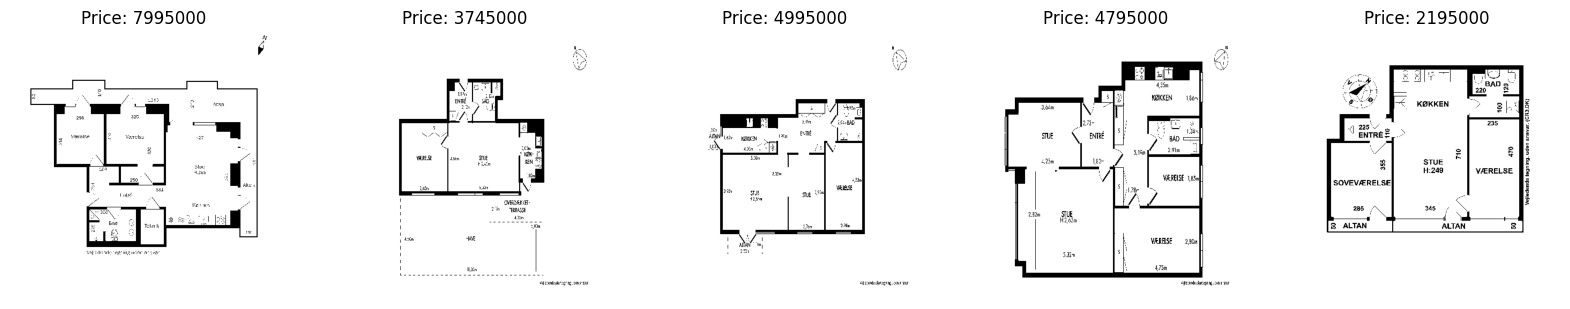

In [13]:
target_width = 500
target_height = 500

train_images_RGB = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize = True, gray_scale = False, threshhold = True)
validation_images_RGB = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize = True, gray_scale = False, threshhold = True)
test_images_RGB = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize = True, gray_scale = False, threshhold = True)

train_prices = train_df['price']
validation_prices = valid_df['price']
test_prices = test_df['price']

#Plot the first 5 images and their prices 
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(train_images_RGB[i])
    ax[i].set_title(f"Price: {train_prices.iloc[i]}")
    ax[i].axis('off')
plt.show()


# Pre-trained VGG16

## Model Fitting

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from multiprocessing import Process, Queue

def train_model():
    set_gpu()
    
    # Load pre-trained VGG16 model (without including top layers)
    input_shape = train_images_RGB[0].shape 
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add new top layers for regression
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(1, activation="linear")
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')
    model.summary()

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_images_RGB, train_df["price"], validation_data=(validation_images_RGB, valid_df["price"]), epochs=50, callbacks=[early_stopping], use_multiprocessing=True) 

    model.save("./VVG16_model")

p = Process(target=train_model)
p.start()
p.join()

1 Physical GPUs, 1 Logical GPU


2024-02-14 10:47:09.339098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:47:09.368108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:47:09.368233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:47:09.370578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:47:09.370742: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 512)               58982912  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73829185 (281.64 MB)
Trainable params: 59114497 (225.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 

2024-02-14 10:47:11.569379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 10:47:11.765597: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 10:47:13.901934: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-14 10:47:13.902008: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-02-14 10:47:19.631177: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allo

8/8 [==============================] - 62s 5s/step - loss: 4100466.2500 - val_loss: 4207654.0000
Epoch 2/50
8/8 [==============================] - 5s 598ms/step - loss: 4356471.0000 - val_loss: 3906688.2500
Epoch 3/50
8/8 [==============================] - 5s 595ms/step - loss: 3371028.0000 - val_loss: 1283602.7500
Epoch 4/50
8/8 [==============================] - 4s 564ms/step - loss: 1989305.8750 - val_loss: 1303297.1250
Epoch 5/50
8/8 [==============================] - 5s 581ms/step - loss: 1733088.7500 - val_loss: 1277829.0000
Epoch 6/50
8/8 [==============================] - 4s 565ms/step - loss: 1353062.8750 - val_loss: 1246230.3750
Epoch 7/50
8/8 [==============================] - 5s 582ms/step - loss: 1098879.5000 - val_loss: 1187049.3750
Epoch 8/50
8/8 [==============================] - 5s 588ms/step - loss: 905190.1875 - val_loss: 1191382.2500
Epoch 9/50
8/8 [==============================] - 5s 582ms/step - loss: 734926.6250 - val_loss: 1184765.0000
Epoch 10/50
8/8 [========

INFO:tensorflow:Assets written to: ./VVG16_model/assets


## Model Evaluation

In [18]:
def evaluate_model(queue: Queue):
    set_gpu()
    
    # Evaluate the model
    loaded_model = tf.keras.models.load_model("./VVG16_model")
    loaded_model.evaluate(test_images_RGB, test_df["price"])
    predictions = loaded_model.predict(test_images_RGB)
    
    queue.put(predictions)

1 Physical GPUs, 1 Logical GPU


2024-02-14 10:46:17.844138: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:46:17.874128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:46:17.874301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:46:17.876668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 10:46:17.876814: I external/local_xla/xla/stream_executor

1/3 [=========>....................] - ETA: 56s - loss: 2681324.0000

2024-02-14 10:46:49.753780: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3/3 [==============================] - 1s 467ms/step
R2 score: 0.16
Mean Absolute Error: 2132621.15
Mean Squared Error: 9638760169262.77


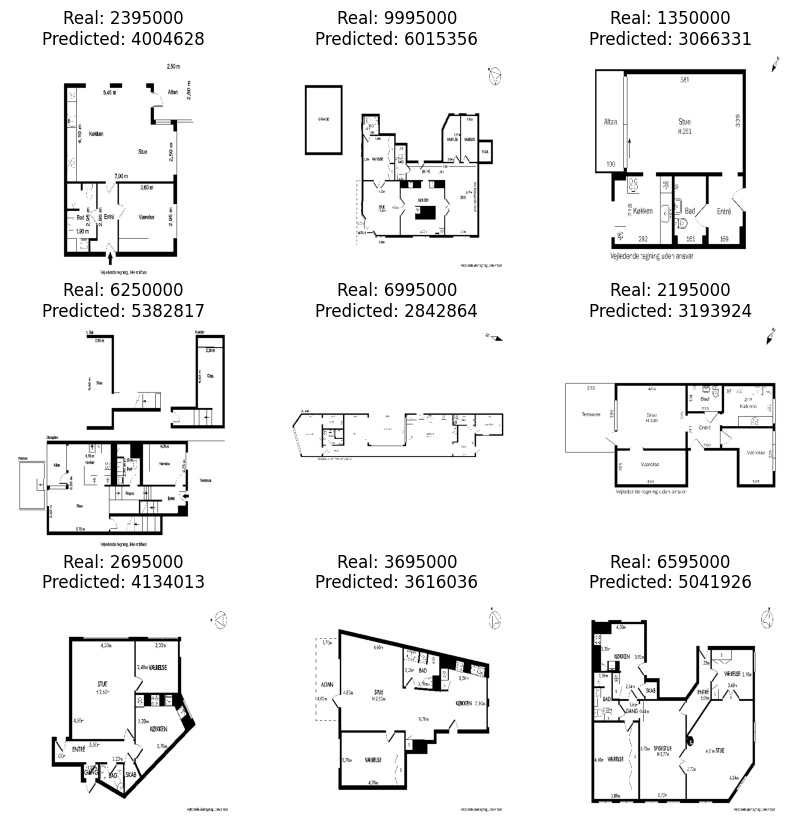

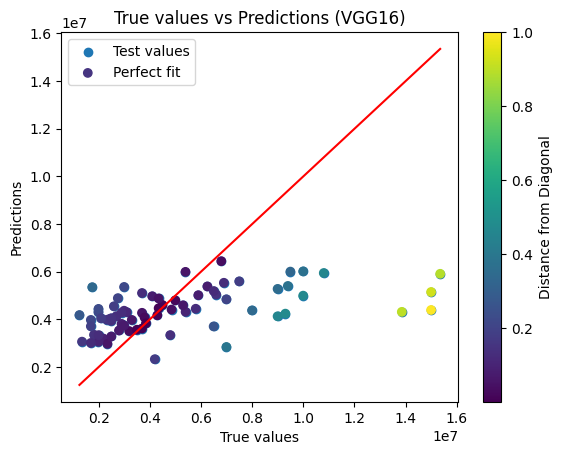

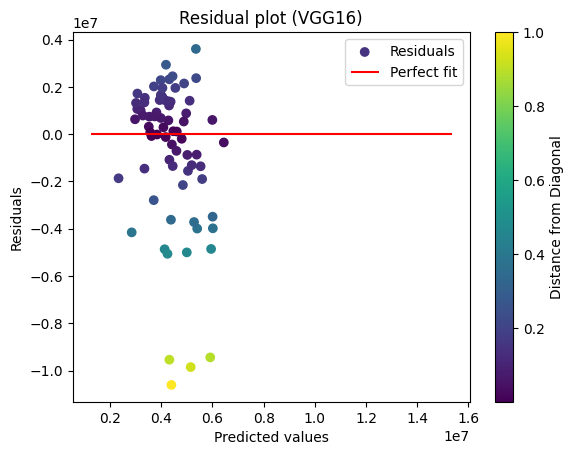

In [21]:
queue = Queue()
p = Process(target=evaluate_model, args=(queue,))
p.start()
p.join()

if queue.empty():
    raise ValueError("Nothing was returned from the process")
predictions = queue.get()
real_prices = test_df['price'].values
predicted_prices = predictions.flatten()

# Print the R2 score, MAE and MSE
print(f"R2 score: {r2_score(real_prices, predicted_prices):.2f}")
print(f"Mean Absolute Error: {mae(real_prices, predicted_prices):.2f}")
print(f"Mean Squared Error: {mse(real_prices, predicted_prices):.2f}")

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images_RGB[0:9], test_df["price"][0:9], predictions[0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction[0]:.0f}")
    plt.axis("off")
plt.show()

# Plot the predictions vs real prices
plot_regression_results('VGG16', real_prices, predicted_prices)